<a href="https://colab.research.google.com/github/FestusMikhael/DeepLearning_EksplorasiResNet-34/blob/main/Tahap_2_ResNet_34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torchinfo

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

# --- 1. Definisi Residual Block (BasicBlock) ---
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        # 1. Konvolusi 3x3 pertama
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # 2. Konvolusi 3x3 kedua
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

        # Residual Connection / Shortcut Path
        self.shortcut = nn.Sequential()

        # Jika dimensi input (in_channels) dan output (out_channels) berbeda,
        # atau ada downsampling (stride > 1), kita harus mengubah dimensi shortcut
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        identity = x # Simpan input untuk Residual Connection

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # Penambahan Residual: Output + Shortcut(Input)
        out += self.shortcut(identity)
        out = self.relu(out)

        return out

# --- 2. Definisi Model ResNet-34 ---
# Struktur ResNet ini sama persis dengan Plain34,
# hanya saja menggunakan BasicBlock (yang memiliki residual connection).
class ResNet34(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000):
        super(ResNet34, self).__init__()
        self.in_channels = 64

        # Lapisan awal
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Lapisan-lapisan utama (Stages)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Lapisan akhir
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # Inisialisasi bobot
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        # Tambahkan blok pertama dengan downsampling (jika stride > 1 atau dimensi berubah)
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion

        # Tambahkan blok sisanya
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels, 1))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def create_resnet34(num_classes=5):
    """Fungsi pembangun untuk ResNet-34"""
    # [3, 4, 6, 3] adalah jumlah blok untuk ResNet-34
    return ResNet34(BasicBlock, [3, 4, 6, 3], num_classes=num_classes)

print("Cell 1: Definisi Model ResNet-34 Selesai.")

Cell 1: Definisi Model ResNet-34 Selesai.


In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import pandas as pd
from google.colab import drive

# 1. MOUNT GOOGLE DRIVE
drive.mount('/content/drive')
print("Google Drive berhasil di-mount.")

# 2. KONFIGURASI HYPERPARAMETER
HYPERPARAMS = {
    'learning_rate': 0.01,
    'batch_size': 16,
    'num_epochs': 10,
    'momentum': 0.9,
    'weight_decay': 1e-4,
    'num_classes': 5,
    'input_size': 224,
    'dataset_path': '/content/drive/MyDrive/IF25-4041-dataset', # PATH ANDA
}

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {DEVICE}")

RESULTS_DIR = '/content/drive/MyDrive/Model_Results'
os.makedirs(RESULTS_DIR, exist_ok=True)

# 3. TRANSFORMASI DATA
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(HYPERPARAMS['input_size']),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(HYPERPARAMS['input_size']),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 4. CUSTOM DATASET (MEMBACA DARI CSV)
class IndonesianFoodDataset(Dataset):
    """Membaca file gambar dan label dari CSV."""
    def __init__(self, data_root, csv_file, transform=None):
        self.data_root = data_root
        self.transform = transform

        # Baca CSV
        self.data_frame = pd.read_csv(csv_file)

        # ASUMSI KOLOM CSV: 'filename' dan 'label'. Sesuaikan jika beda!
        self.filenames = self.data_frame['filename'].values
        self.labels = self.data_frame['label'].values

        # Buat pemetaan label string ke integer (0, 1, 2, 3, 4)
        unique_labels = sorted(self.data_frame['label'].unique())
        self.label_to_idx = {label: i for i, label in enumerate(unique_labels)}

        # Konversi label string di DataFrame menjadi integer index
        self.labels = [self.label_to_idx[label] for label in self.labels]

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        label = self.labels[idx]

        img_path = os.path.join(self.data_root, img_name)

        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            # Jika gambar tidak ada (misalnya ada di CSV tapi file tidak ada)
            print(f"File tidak ditemukan: {img_path}. Melewatkan.")
            return None, None

        if self.transform:
            image = self.transform(image)

        return image, label

# 5. MUAT DATASET DAN SPLIT (Train Asli -> Train & Val)
TRAIN_DIR = os.path.join(HYPERPARAMS['dataset_path'], 'train')
TRAIN_CSV = os.path.join(HYPERPARAMS['dataset_path'], 'train.csv')

try:
    # Muat SELURUH data training
    full_train_dataset = IndonesianFoodDataset(
        data_root=TRAIN_DIR,
        csv_file=TRAIN_CSV,
        transform=data_transforms['train']
    )

    if len(full_train_dataset) == 0:
        raise ValueError("Dataset 'train' kosong. Cek 'train.csv' dan folder 'train'.")

    # Split 85% Train, 15% Val
    train_size = int(0.85 * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size

    train_dataset, val_dataset = random_split(
        full_train_dataset, [train_size, val_size]
    )

    train_loader = DataLoader(train_dataset, batch_size=HYPERPARAMS['batch_size'], shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=HYPERPARAMS['batch_size'], shuffle=False, num_workers=2)

    print("\n--- Data Loading Berhasil ---")
    print(f"Total Data: {len(full_train_dataset)}")
    print(f"Data Train (85%): {len(train_dataset)}")
    print(f"Data Val (15%): {len(val_dataset)}")

except ValueError as e:
    print(f"\n[ERROR KRITIS] {e}")
    print(f"Cek path: {TRAIN_CSV} dan {TRAIN_DIR}")
except Exception as e:
    print(f"\n[ERROR UMUM] Gagal memuat data: {e}")

print("Cell 2: Setup dan Data Loading Selesai.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive berhasil di-mount.
Menggunakan device: cuda:0

--- Data Loading Berhasil ---
Total Data: 1108
Data Train (85%): 941
Data Val (15%): 167
Cell 2: Setup dan Data Loading Selesai.


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import pandas as pd
import time

# --- 1. FUNGSI PELATIHAN INTU ---
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    start_time = time.time()
    history = pd.DataFrame(columns=['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc'])

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print('-' * 10)

        # FASE TRAINING
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()

        epoch_loss_train = running_loss / len(train_dataset)
        epoch_acc_train = running_corrects.double() / len(train_dataset)

        # FASE VALIDASI
        model.eval()
        running_loss_val = 0.0
        running_corrects_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss_val += loss.item() * inputs.size(0)
                running_corrects_val += torch.sum(preds == labels.data)

        epoch_loss_val = running_loss_val / len(val_dataset)
        epoch_acc_val = running_corrects_val.double() / len(val_dataset)

        print(f"Train Loss: {epoch_loss_train:.4f} | Train Acc: {epoch_acc_train:.4f}")
        print(f"Val Loss: {epoch_loss_val:.4f} | Val Acc: {epoch_acc_val:.4f}")

        history.loc[epoch] = [epoch + 1, epoch_loss_train, epoch_acc_train.item(), epoch_loss_val, epoch_acc_val.item()]

    time_elapsed = time.time() - start_time
    print(f'\nPelatihan selesai dalam {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model, history

# --- 2. INISIALISASI DAN EKSEKUSI PELATIHAN ---
print("\n" + "="*50)
print("MEMULAI PELATIHAN PLAIN-34 (BASELINE)")
print("="*50)

# Inisialisasi Model
model = create_resnet34(num_classes=HYPERPARAMS['num_classes'])
model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=HYPERPARAMS['learning_rate'],
    momentum=HYPERPARAMS['momentum'],
    weight_decay=HYPERPARAMS['weight_decay']
)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

# Latih model
model_plain, history_plain = train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    num_epochs=HYPERPARAMS['num_epochs']
)

# Penyimpanan Hasil
history_path = os.path.join(RESULTS_DIR, 'resnet34_history.csv')
history_plain.to_csv(history_path, index=False)
torch.save(model_plain.state_dict(), os.path.join(RESULTS_DIR, 'resnet34.pth'))

print("\n" + "="*50)
print("PELATIHAN BASELINE SELESAI!")
print(f"History dan bobot model disimpan di: {RESULTS_DIR}")
print("="*50)


MEMULAI PELATIHAN PLAIN-34 (BASELINE)

Epoch 1/10
----------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.0757 | Train Acc: 0.2848
Val Loss: 5.2248 | Val Acc: 0.3054

Epoch 2/10
----------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.5930 | Train Acc: 0.3826
Val Loss: 1.3169 | Val Acc: 0.4371

Epoch 3/10
----------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.3934 | Train Acc: 0.4623
Val Loss: 1.5700 | Val Acc: 0.4671

Epoch 4/10
----------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.2064 | Train Acc: 0.5197
Val Loss: 1.1064 | Val Acc: 0.5389

Epoch 5/10
----------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.1605 | Train Acc: 0.5632
Val Loss: 1.4067 | Val Acc: 0.5868

Epoch 6/10
----------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.3231 | Train Acc: 0.5122
Val Loss: 1.5365 | Val Acc: 0.4790

Epoch 7/10
----------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.1722 | Train Acc: 0.5622
Val Loss: 1.0820 | Val Acc: 0.6287

Epoch 8/10
----------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.9986 | Train Acc: 0.6206
Val Loss: 0.8272 | Val Acc: 0.6467

Epoch 9/10
----------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.9560 | Train Acc: 0.6312
Val Loss: 0.8375 | Val Acc: 0.6407

Epoch 10/10
----------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.9201 | Train Acc: 0.6631
Val Loss: 0.8406 | Val Acc: 0.6647

Pelatihan selesai dalam 4m 20s

PELATIHAN BASELINE SELESAI!
History dan bobot model disimpan di: /content/drive/MyDrive/Model_Results


Kedua file history berhasil dimuat.


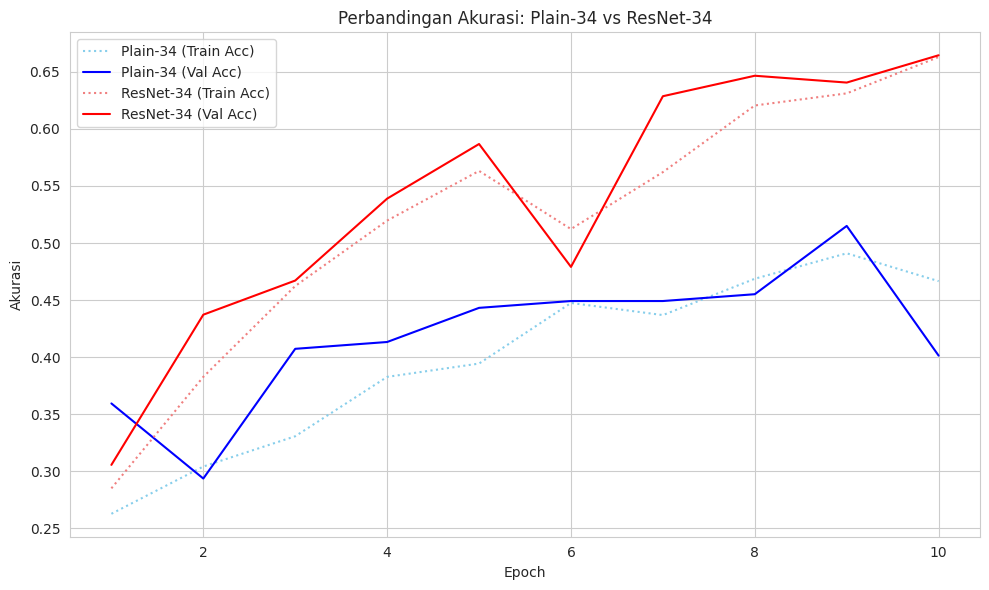

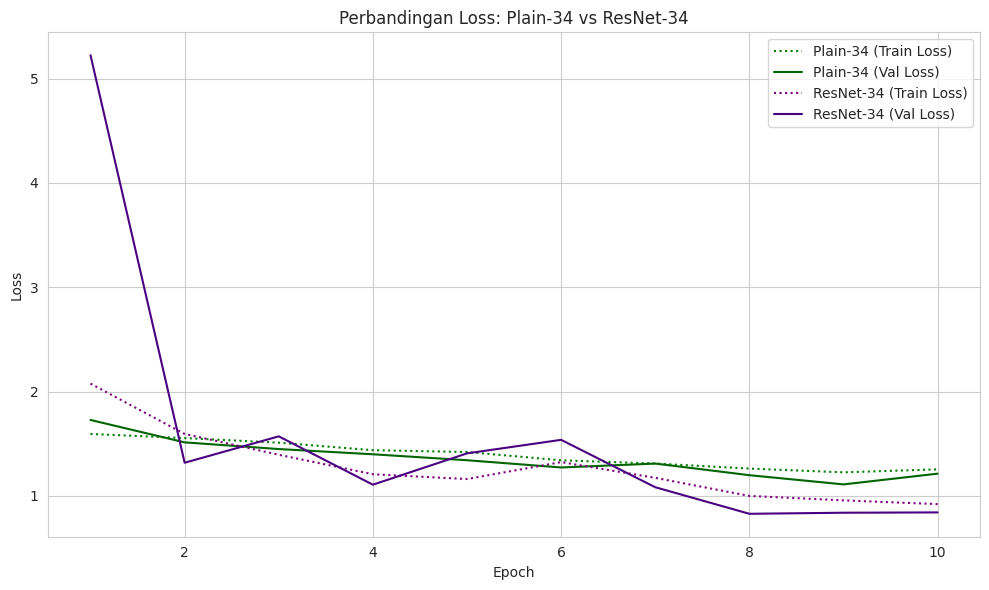

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

# Set style untuk tampilan grafik yang lebih baik
sns.set_style("whitegrid")

# Path ke folder hasil Anda
RESULTS_DIR = '/content/drive/MyDrive/Model_Results'

# Path ke kedua file history
PLAIN_HISTORY_PATH = os.path.join(RESULTS_DIR, 'plain34_baseline_history.csv')
RESNET_HISTORY_PATH = os.path.join(RESULTS_DIR, 'resnet34_history.csv')

# --- 1. Memuat Data ---
try:
    df_plain = pd.read_csv(PLAIN_HISTORY_PATH)
    df_resnet = pd.read_csv(RESNET_HISTORY_PATH)
    print("Kedua file history berhasil dimuat.")
except FileNotFoundError:
    print("ERROR: Salah satu atau kedua file history tidak ditemukan. Pastikan nama file dan path sudah benar.")
    # Keluar dari blok kode jika file tidak ditemukan
    raise

# --- 2. Grafik Akurasi (Training & Validation) ---
plt.figure(figsize=(10, 6))

# Plot Plain-34
plt.plot(df_plain['epoch'], df_plain['train_acc'], label='Plain-34 (Train Acc)', linestyle=':', color='skyblue')
plt.plot(df_plain['epoch'], df_plain['val_acc'], label='Plain-34 (Val Acc)', color='blue')

# Plot ResNet-34
plt.plot(df_resnet['epoch'], df_resnet['train_acc'], label='ResNet-34 (Train Acc)', linestyle=':', color='lightcoral')
plt.plot(df_resnet['epoch'], df_resnet['val_acc'], label='ResNet-34 (Val Acc)', color='red')

plt.title('Perbandingan Akurasi: Plain-34 vs ResNet-34')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.tight_layout()
plt.show()


# --- 3. Grafik Loss (Training & Validation) ---
plt.figure(figsize=(10, 6))

# Plot Plain-34 Loss
plt.plot(df_plain['epoch'], df_plain['train_loss'], label='Plain-34 (Train Loss)', linestyle=':', color='green')
plt.plot(df_plain['epoch'], df_plain['val_loss'], label='Plain-34 (Val Loss)', color='darkgreen')

# Plot ResNet-34 Loss
plt.plot(df_resnet['epoch'], df_resnet['train_loss'], label='ResNet-34 (Train Loss)', linestyle=':', color='purple')
plt.plot(df_resnet['epoch'], df_resnet['val_loss'], label='ResNet-34 (Val Loss)', color='indigo')

plt.title('Perbandingan Loss: Plain-34 vs ResNet-34')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()